In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from pytorch3d.ops import sample_farthest_points

In [17]:
folder_path = "samples_data"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
epochs = 200
lr = 0.001
num_layers = 3
hidden_size= 256
input_size = 2 #non si considera la y
past_seconds = 2
future_seconds = 4
framerate = 10

## Calcolo e salvataggio subsampling delle nuvole di punti

In [3]:
def extract_number(filename):
    return int(filename.split('_')[1].split('.')[0])

In [ ]:
all_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]        
npz_files = sorted(all_files, key=extract_number)

point_clouds_subsampled = []

with torch.no_grad():
    for file_name in npz_files:
        file_path = os.path.join(folder_path, file_name)
        data = np.load(file_path)

        # Prende la nuvola di punti e la mette su GPU
        point_cloud = torch.tensor(data["point_cloud"], dtype=torch.float32).unsqueeze(0).to(device)

        # Calcola la nuvola di punti sottocampionata
        sampled_pc = sample_farthest_points(point_cloud, K=1024)[0].squeeze(0).cpu().numpy()

        # Salva la nuvola sottocampionata nella lista
        point_clouds_subsampled.append(sampled_pc)

# Salva le nuvole sottocampionate in un file NPZ
np.savez_compressed("point_clouds_subsampled.npz", subsampling=np.array(point_clouds_subsampled))

print("Subsampled point clouds saved in 'point_clouds_subsampled.npz'!")

Subsampled point clouds saved in 'point_clouds_subsampled.npz'!


## Sezione addestramento del modello

In [18]:
class PointNetfeat(nn.Module):
    def __init__(self):
        super(PointNetfeat, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        return x

In [19]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, point_clouds_subsampled, past_seconds=2, future_seconds=4, framerate=10):
        self.folder_path = folder_path
        self.past_frames = framerate * past_seconds
        self.future_frames = framerate * future_seconds
        self.point_clouds_subsampled = point_clouds_subsampled

        def extract_number(filename):
            return int(filename.split('_')[1].split('.')[0])

        all_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]
        self.npz_files = sorted(all_files, key=extract_number)

    def __len__(self):
        return len(self.npz_files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, self.npz_files[idx])
        data = np.load(file_path)

        # Converte i dati in tensori PyTorch
        past_trajectory = torch.tensor(np.delete(data["past_trajectory"], 1, 1), dtype=torch.float32)
        future_trajectory = torch.tensor(np.delete(data["future_trajectory"], 1, 1), dtype=torch.float32)
        point_clouds_subsampled = (self.point_clouds_subsampled[idx]).transpose(0, 1)

        past_trajectory = past_trajectory[:self.past_frames]
        future_trajectory = future_trajectory[:self.future_frames]

        return past_trajectory, future_trajectory, point_clouds_subsampled

In [20]:
class MyModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=256, output_size=2*40, num_layers=3, future_steps=40):
        super(MyModel, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.future_steps = future_steps
        
        self.pointnet = PointNetfeat()
        self.pc_emb_proj = nn.Linear(1024, self.hidden_size)
        self.pc_emb_norm = nn.LayerNorm(self.hidden_size)
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=0.3, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, pc):
        pc = pc.to(x.device)
        pc_emb = self.pointnet(pc)
        pc_emb = self.pc_emb_norm(self.pc_emb_proj(pc_emb))

        h0 = pc_emb.unsqueeze(0).repeat(self.num_layers, 1, 1).to(x.device)
        
        _, h = self.gru(x, h0) # out contiene tutti gli hidden state (dell'ultimo layer della GRU) di tutta la 
                                 # sequenza ed ha quindi dimensione [batch_size, seq_length, hidden_dim]
                                 # h contiene l'ultimo hidden state della sequenza di ogni layer della GRU, ed ha dimensione
                                 # [num_layers, batch_size, hidden_dim]
        
        last_hidden = h[-1]  # [batch_size, hidden_size]
        future_points = self.fc(last_hidden)  # [batch_size, 2*future_steps]
        future_points = future_points.view(x.size(0), self.future_steps, self.input_size)
             
        return future_points

In [21]:
def train(model, device, train_loader, optimizer, epoch, global_x_std, global_z_std):
    model.train() # setta il modello in training mode
    
    lambda_x = 1./global_x_std
    lambda_z = 1./global_z_std
    
    train_mse_x = 0
    train_mse_z = 0
    train_mse_total = 0
    total_samples = 0

    for past, future, pc in train_loader: # iterazione sui batch
        past, future = past.to(device), future.to(device) #spostamento traiettoria passata e futura sulla GPU
        optimizer.zero_grad() #azzera i gradienti

        future_pred = model(past, pc) #viene eseguito il forward

        #calcolo delle loss, con la somma per normalizzare
        loss_x = F.mse_loss(future_pred[:, :, 0], future[:, :, 0], reduction='sum') # MSE su x
        loss_z = F.mse_loss(future_pred[:, :, -1], future[:, :, -1], reduction='sum') # MSE su z
        loss_total = lambda_x * loss_x + lambda_z * loss_z  
        
        train_mse_x += loss_x.item()
        train_mse_z += loss_z.item()
        train_mse_total += loss_total.item()

        loss_total.backward() # calcola i gradienti
        optimizer.step() # aggiorna i pesi

        total_samples += future.size(0) * future.size(1)  # numero totale di punti della traiettoria

    # normalizzazione per ottenere la media
    train_mse_x /= total_samples
    train_mse_z /= total_samples
    train_mse_total /= total_samples

    print(f'Train Epoch {epoch}: MSE Total = {train_mse_total:.6f},   MSE X = {train_mse_x:.6f},   MSE Z = {train_mse_z:.6f}')

    return train_mse_total, train_mse_x, train_mse_z

In [22]:
def test(model, device, test_loader, global_x_std, global_z_std):
    model.eval() #setta il modello in evaluation mode
    
    lambda_x = 1./global_x_std
    lambda_z = 1./global_z_std
    
    test_mse_x, test_mse_z, test_mse_total = 0, 0, 0
    total_samples = 0

    with torch.no_grad():
        for past, future, pc in test_loader:
            past, future = past.to(device), future.to(device)
            future_pred = model(past, pc)

            loss_x = F.mse_loss(future_pred[:, :, 0], future[:, :, 0], reduction='sum')  # MSE su x
            loss_z = F.mse_loss(future_pred[:, :, -1], future[:, :, -1], reduction='sum')  # MSE su z
            loss_total = lambda_x * loss_x + lambda_z * loss_z
            
            test_mse_x += loss_x.item()
            test_mse_z += loss_z.item()
            test_mse_total += loss_total.item()

            total_samples += future.size(0) * future.size(1)

    # normalizzazione per ottenere la media
    test_mse_x /= total_samples
    test_mse_z /= total_samples
    test_mse_total /= total_samples

    print(f'Test: MSE Total = {test_mse_total:.6f},   MSE X = {test_mse_x:.6f},   MSE Z = {test_mse_z:.6f}')
    return test_mse_total, test_mse_x, test_mse_z

In [23]:
def plot_loss(epochs, train_losses_total, test_losses_total, train_losses_x, test_losses_x, train_losses_z, test_losses_z):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 riga, 3 colonne

    # Plot per la loss totale
    axes[0].plot(range(1, epochs + 1), train_losses_total, marker='o', color='red', label="Train Total loss")
    axes[0].plot(range(1, epochs + 1), test_losses_total, marker='o', color='blue', label="Test Total loss")
    axes[0].set_xticks([1] + list(range(20, epochs + 1, 20)))
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].set_title('Total Loss')

    # Plot per la loss su X
    axes[1].plot(range(1, epochs + 1), train_losses_x, marker='o', color='red', label="Train X loss")
    axes[1].plot(range(1, epochs + 1), test_losses_x, marker='o', color='blue', label="Test X loss")
    axes[1].set_xticks([1] + list(range(20, epochs + 1, 20)))
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].set_title('X Loss')

    # Plot per la loss su Z
    axes[2].plot(range(1, epochs + 1), train_losses_z, marker='o', color='red', label="Train Z loss")
    axes[2].plot(range(1, epochs + 1), test_losses_z, marker='o', color='blue', label="Test Z loss")
    axes[2].set_xticks([1] + list(range(20, epochs + 1, 20)))
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].set_title('Z Loss')

    plt.tight_layout()  # Per evitare sovrapposizioni
    plt.show()

In [24]:
loaded_pc_subsampled = np.load("point_clouds_subsampled.npz")
point_clouds_subsampled = [torch.tensor(subsampling, dtype=torch.float32) for subsampling in 
                           loaded_pc_subsampled["subsampling"]]

dataset = CustomDataset(folder_path=folder_path, point_clouds_subsampled=point_clouds_subsampled, past_seconds=past_seconds, 
                        future_seconds=future_seconds, framerate=framerate)

generator = torch.Generator().manual_seed(42) # per avere lo stesso split di train/test ad ogni esecuzione
train_set, test_set = random_split(dataset, [0.75, 0.25], generator=generator)
'''
train_size = int(0.75 * len(dataset))

train_set = Subset(dataset, list(range(train_size)))
test_set = Subset(dataset, list(range(train_size, len(dataset))))
'''
train_loader = DataLoader(train_set, num_workers=2, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, num_workers=2, batch_size=batch_size, shuffle=False)

In [25]:
for past, future, pc in train_loader:
    print(past.shape)
    print(future.shape)
    print(pc.shape)
    break

torch.Size([64, 20, 2])
torch.Size([64, 40, 2])
torch.Size([64, 3, 1024])


In [26]:
#Calcolo della varianza e della deviazione standard globali di x e di z

all_x_values = []
all_z_values = []

for past, future, _ in train_set + test_set:
    all_x_values.append(past[:, 0])
    all_x_values.append(future[:, 0])
    all_z_values.append(past[:, 1])
    all_z_values.append(future[:, 1])

#Concatenazione di tutti i punti
all_x_values = torch.cat(all_x_values)
all_z_values = torch.cat(all_z_values)

global_x_variance = torch.var(all_x_values)
global_z_variance = torch.var(all_z_values)

global_x_std = global_x_variance ** 0.5
global_z_std = global_z_variance ** 0.5

print(f"Global variance of the x-coordinate: {global_x_variance.item()}")
print(f"Global variance of the z-coordinate: {global_z_variance.item()}")

Global variance of the x-coordinate: 0.3510107398033142
Global variance of the z-coordinate: 4.372647285461426


In [ ]:
batch = next(iter(test_loader))  # Prende un batch dal test_loader
past_batch, future_batch, _ = batch

for points in past_batch:
    print(points.shape)
    print(points[0])


for i in range(2):  # Plotta solo 2 esempi
    past = past_batch[i].numpy()
    future = future_batch[i].numpy()

    plt.figure(figsize=(5, 5))
    plt.plot(past[:, 0], past[:, 1], 'go-', label='Past Trajectory')
    plt.plot(future[:, 0], future[:, 1], 'ro-', label='Future Trajectory')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.legend()
    plt.title(f"Sample {i+1}")
    plt.show()

In [35]:
model = MyModel(input_size=input_size, hidden_size=hidden_size, output_size=input_size*future_seconds*framerate, 
              num_layers=num_layers, future_steps=future_seconds*framerate).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

best_weights = copy.deepcopy(model.state_dict())
best_epoch = 0
best_test_loss = float("inf")

train_losses_x = []
train_losses_z = []
train_losses_total = []
test_losses_x = []
test_losses_z = []
test_losses_total = []

start_time = time.time()

for epoch in range(1, epochs + 1):
    #esegue un'epoca di training
    train_loss_total, train_loss_x, train_loss_z = train(model, device, train_loader, optimizer, epoch,
                                                         global_x_std, global_z_std)
    test_loss_total, test_loss_x, test_loss_z = test(model, device, test_loader, global_x_std, global_z_std)

    if(test_loss_total < best_test_loss):
        best_epoch = epoch
        best_test_loss = test_loss_total
        best_weights = copy.deepcopy(model.state_dict()) 

    train_losses_total.append(train_loss_total)
    train_losses_x.append(train_loss_x)
    train_losses_z.append(train_loss_z)
    test_losses_total.append(test_loss_total)
    test_losses_x.append(test_loss_x)
    test_losses_z.append(test_loss_z)
    print("\n")

model.load_state_dict(best_weights)
print(f"Got the weights of the epoch {best_epoch}")

end_time = time.time()

execution_time = end_time - start_time

minutes, seconds = divmod(execution_time, 60) #converte il tempo in minuti e secondi

print(f"Execution time: {int(minutes)} minutes, {seconds:.2f} seconds")

Train Epoch 1: MSE Total = 1.354925,   MSE X = 0.501649,   MSE Z = 1.062701
Test: MSE Total = 0.855855,   MSE X = 0.432271,   MSE Z = 0.263972


Train Epoch 2: MSE Total = 0.791500,   MSE X = 0.395221,   MSE Z = 0.260168
Test: MSE Total = 0.740332,   MSE X = 0.369263,   MSE Z = 0.244788


Train Epoch 3: MSE Total = 0.752160,   MSE X = 0.373657,   MSE Z = 0.254015
Test: MSE Total = 0.743890,   MSE X = 0.371812,   MSE Z = 0.243231


Train Epoch 4: MSE Total = 0.715530,   MSE X = 0.353918,   MSE Z = 0.247086
Test: MSE Total = 0.679340,   MSE X = 0.336810,   MSE Z = 0.231794


Train Epoch 5: MSE Total = 0.651506,   MSE X = 0.319715,   MSE Z = 0.233924
Test: MSE Total = 0.624074,   MSE X = 0.302498,   MSE Z = 0.237331


Train Epoch 6: MSE Total = 0.663300,   MSE X = 0.325277,   MSE Z = 0.238958
Test: MSE Total = 0.603571,   MSE X = 0.294867,   MSE Z = 0.221392


Train Epoch 7: MSE Total = 0.595799,   MSE X = 0.288589,   MSE Z = 0.227296
Test: MSE Total = 0.568657,   MSE X = 0.277383,   MSE 

In [36]:
torch.save(model.state_dict(), "model_weights_step2_one_shot")

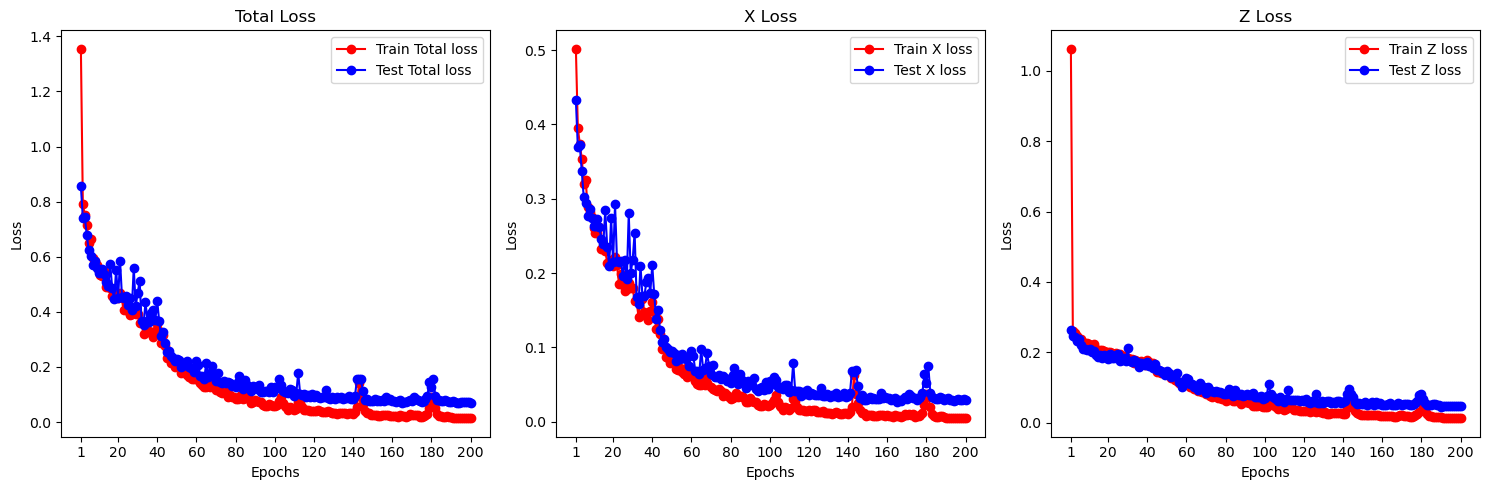

In [37]:
plot_loss(len(train_losses_total), train_losses_total, test_losses_total, train_losses_x, test_losses_x, train_losses_z, 
          test_losses_z)

## Evaluation

In [38]:
model = MyModel(input_size=input_size, hidden_size=hidden_size, output_size=input_size*future_seconds*framerate, 
              num_layers=num_layers, future_steps=future_seconds*framerate).to(device=device)
model.load_state_dict(torch.load("model_weights_step2_one_shot"))

model.eval()

MyModel(
  (pointnet): PointNetfeat(
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pc_emb_proj): Linear(in_features=1024, out_features=256, bias=True)
  (pc_emb_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (gru): GRU(2, 256, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=80, bias=True)
)

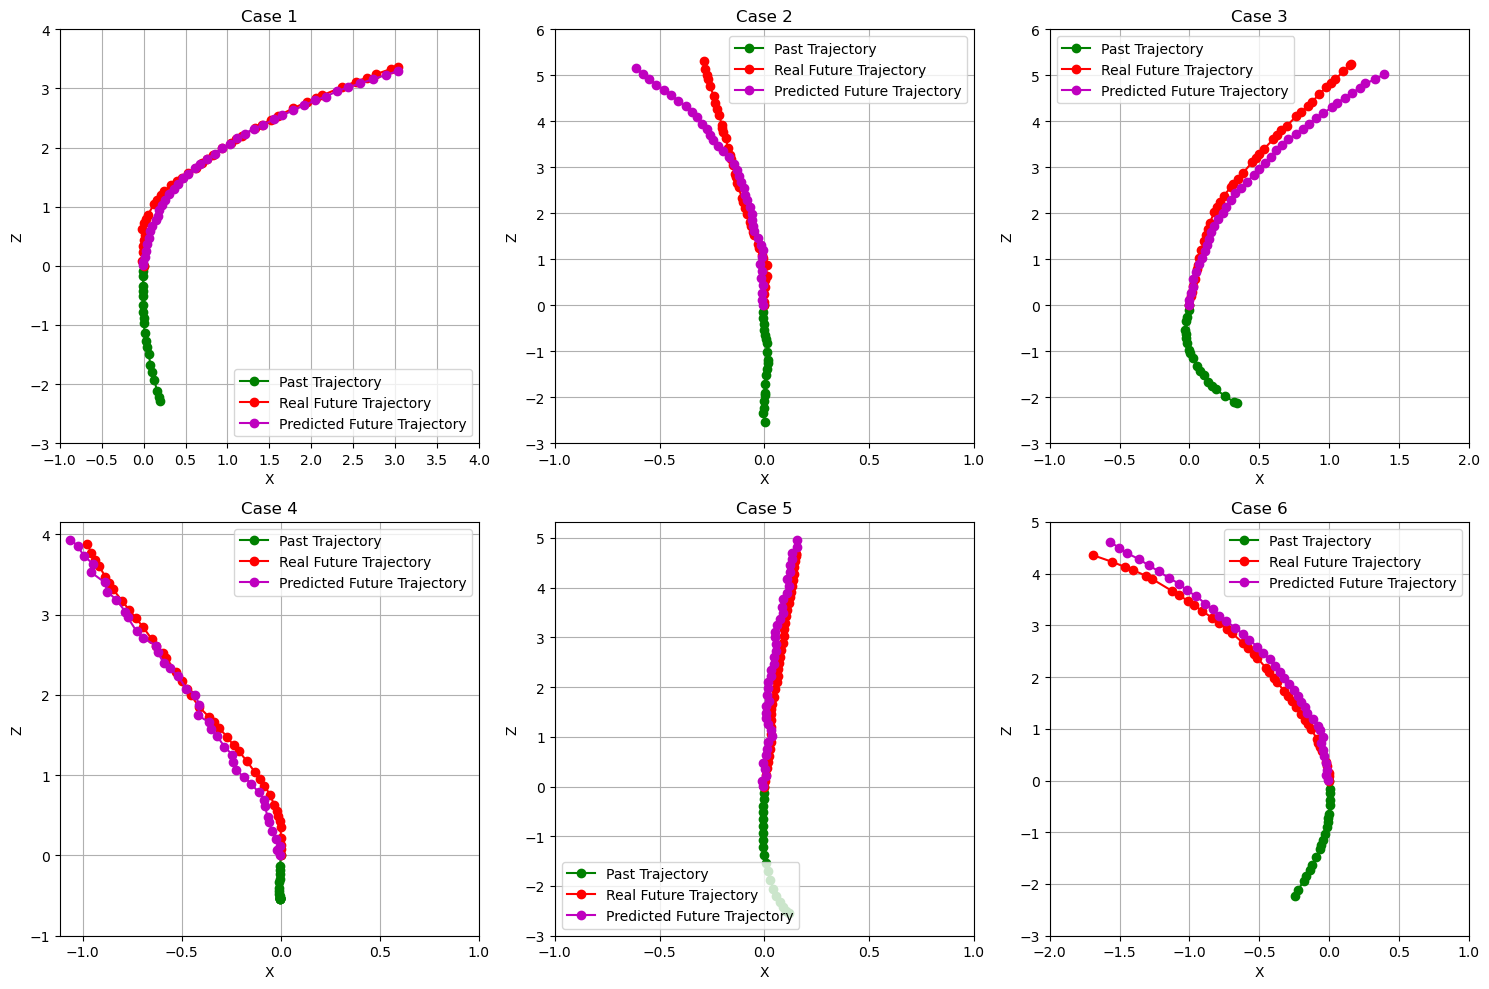

In [42]:
model.eval()

batch = next(iter(test_loader)) # prende un batch dal test_loader
past_batch, future_batch, pc_batch = batch  # estrae passato, futuro e embedding della point-cloud dal batch

# seleziona tre esempi diversi dal batch
indices = [5, 10, 15, 20, 25, 26]  # indici di sei campioni
examples = [(past_batch[i], future_batch[i], pc_batch[i]) for i in indices]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (past, future, pc) in enumerate(examples):
    
    all_points = torch.cat((past, future), 0)
    past = past.cpu().numpy()
    future = future.cpu().numpy()

    # Predizione del modello
    past_tensor = past_batch[indices[i]].unsqueeze(0).to(device)  # prende un campione e aggiunge batch dim
    pc_tensor = pc_batch[indices[i]].unsqueeze(0).to(device)
    with torch.no_grad():
        predicted_future = model(past_tensor, pc_tensor).squeeze(0).cpu().detach().numpy() # predice e converte in numpy

    row, col = divmod(i, 3)  # Converte i in (riga, colonna)

    # Plot
    axes[row, col].plot(past[:, 0], past[:, 1], 'g-o', label="Past Trajectory") 
    axes[row, col].plot(future[:, 0], future[:, 1], 'r-o', label="Real Future Trajectory") 
    axes[row, col].plot(predicted_future[:, 0], predicted_future[:, 1], 'm-o', label="Predicted Future Trajectory")
    
    axes[row, col].set_xlabel("X")
    axes[row, col].set_ylabel("Z")
    axes[row, col].set_title(f"Case {i+1}")
    axes[row, col].legend()
    axes[row, col].grid()

    x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
    z_min, z_max = all_points[:, 1].min(), all_points[:, 1].max()
    
    x_min_tick = float(np.floor(float(x_min)))
    x_max_tick = float(np.ceil(float(x_max)))
    z_min_tick = float(np.floor(float(z_min)))
    z_max_tick = float(np.ceil(float(z_max)))

    axes[row, col].set_xticks(np.arange(x_min_tick, x_max_tick + 0.5, 0.5))
    axes[row, col].set_yticks(np.arange(z_min_tick, z_max_tick + 1.0, 1.0))

plt.tight_layout()
plt.show()

In [40]:
def performance_measurement(model, device, train_loader, test_loader):
    model.eval() #setta il modello in evaluation mode
    
    train_ade_x, train_ade_z, train_ade_total = 0, 0, 0
    train_fde_x, train_fde_z, train_fde_total = 0, 0, 0
    test_ade_x, test_ade_z, test_ade_total = 0, 0, 0
    test_fde_x, test_fde_z, test_fde_total = 0, 0, 0
    total_samples = 0

    # Misurazione performance sul train set

    with torch.no_grad():
        for past, future, pc in train_loader:
            past, future = past.to(device), future.to(device)
            future_pred = model(past, pc)

            ade_x = torch.abs(future_pred[:, :, 0] - future[:, :, 0]).sum()
            ade_z = torch.abs(future_pred[:, :, -1] - future[:, :, -1]).sum()
            ade_total = torch.norm(future_pred - future, dim=2).sum()

            fde_x = torch.abs(future_pred[:, -1, 0] - future[:, -1, 0]).sum()
            fde_z = torch.abs(future_pred[:, -1, -1] - future[:, -1, -1]).sum()
            fde_total = torch.norm(future_pred[:, -1, :] - future[:, -1, :], dim=1).sum()
            
            train_ade_x += ade_x.item()
            train_ade_z += ade_z.item()
            train_ade_total += ade_total.item()

            train_fde_x += fde_x.item()
            train_fde_z += fde_z.item()
            train_fde_total += fde_total.item()

            total_samples += future.size(0) * future.size(1)

    train_ade_x /= total_samples
    train_ade_z /= total_samples
    train_ade_total /= total_samples

    train_fde_x /= len(train_loader.dataset)
    train_fde_z /= len(train_loader.dataset)
    train_fde_total /= len(train_loader.dataset)

    print(f'Model performances on train set:')
    print(f'\nADE Total = {train_ade_total:.6f},   ADE X = {train_ade_x:.6f},   ADE Z = {train_ade_z:.6f}')
    print(f'FDE Total = {train_fde_total:.6f},   FDE X = {train_fde_x:.6f},   FDE Z = {train_fde_z:.6f}')

    
    # Misurazione performance sul test set

    total_samples = 0

    with torch.no_grad():
        for past, future, pc in test_loader:
            past, future = past.to(device), future.to(device)
            future_pred = model(past, pc)

            ade_x = torch.abs(future_pred[:, :, 0] - future[:, :, 0]).sum()
            ade_z = torch.abs(future_pred[:, :, -1] - future[:, :, -1]).sum()
            ade_total = torch.norm(future_pred - future, dim=2).sum()

            fde_x = torch.abs(future_pred[:, -1, 0] - future[:, -1, 0]).sum()
            fde_z = torch.abs(future_pred[:, -1, -1] - future[:, -1, -1]).sum()
            fde_total = torch.norm(future_pred[:, -1, :] - future[:, -1, :], dim=1).sum()
            
            test_ade_x += ade_x.item()
            test_ade_z += ade_z.item()
            test_ade_total += ade_total.item()

            test_fde_x += fde_x.item()
            test_fde_z += fde_z.item()
            test_fde_total += fde_total.item()

            total_samples += future.size(0) * future.size(1)

    test_ade_x /= total_samples
    test_ade_z /= total_samples
    test_ade_total /= total_samples

    test_fde_x /= len(test_loader.dataset)
    test_fde_z /= len(test_loader.dataset)
    test_fde_total /= len(test_loader.dataset)

    print(f'\nModel performances on test set:')
    print(f'\nADE Total = {test_ade_total:.6f},   ADE X = {test_ade_x:.6f},   ADE Z = {test_ade_z:.6f}')
    print(f'FDE Total = {test_fde_total:.6f},   FDE X = {test_fde_x:.6f},   FDE Z = {test_fde_z:.6f}')

In [41]:
performance_measurement(model=model, device=device, train_loader=train_loader, test_loader=test_loader)

Model performances on train set:

ADE Total = 0.100151,   ADE X = 0.042870,   ADE Z = 0.080930
FDE Total = 0.176390,   FDE X = 0.090484,   FDE Z = 0.131358

Model performances on test set:

ADE Total = 0.167178,   ADE X = 0.081750,   ADE Z = 0.127207
FDE Total = 0.308424,   FDE X = 0.188509,   FDE Z = 0.202826


In [18]:
def save_prediction(index):    
    model.eval()

    batch = next(iter(test_loader)) # prende un batch dal test_loader
    past_batch, _, pc_batch = batch  # estrae passato e futuro dal batch

    past_tensor = past_batch[index].unsqueeze(0).to(device)  # prende un campione e aggiunge batch dim
    pc_tensor = pc_batch[index].unsqueeze(0).to(device)

    with torch.no_grad():
        predicted_future = model(past_tensor, pc_tensor).squeeze(0).cpu().detach().numpy()  # predice e converte in numpy

    file_name = 'test_predictions_'+str(index)+'.npz'

    with np.load(file_name) as data:
        data_dict = dict(data)

    # Aggiungi la nuova coppia chiave-array
    data_dict['step2_one_shot'] = predicted_future

    # Salva tutto nel file, sovrascrivendo quello originale
    np.savez(file_name, **data_dict)       

In [ ]:
save_prediction(index=5)